In [18]:
# IMPORT
# Standard libray
import sys, os
from importlib import reload
sys.path.append("..")

# Common library
from tqdm import tqdm
import numpy as np
import scipy
from pylab import *
import scipy.interpolate

# ROOT>....
import ROOT
# Make global style changes
ROOT.gStyle.SetOptStat(0) # Disable the statistics box
ROOT.gStyle.SetTextFont(42)
# ROOT.gStyle.SetOptFit(1111)
import atlasplots as aplt
aplt.set_atlas_style()
ROOT.gStyle.SetTitleXOffset(1)
ROOT.gStyle.SetTitleYOffset(1.8)

# Custom helper functions
import MuHelper.muhelper.helper_basic as hp
import helper_tofpet as hptof

# ROOT.gStyle.SetPalette(len(hptof.mpl_colors), hptof.mpl_colors32)
ROOT.gStyle.SetPalette(ROOT.kViridis)
# colors=[int(c) for c in hptof.mpl_colors ]
colors=hptof.mpl_colors_cls()

Applying ATLAS style settings


In [19]:
working_dir = "/mnt/sda2/tofpet_data/test_stand_init/"
filename = working_dir+"processed/"+  "full_cosmic_2_coinc_processed.root"


coinc_pairs = np.loadtxt("../configurations/coinc_pairs.csv", delimiter=",", dtype=int)
coinc_pairs = {(a[0], a[1]):a[2] for a in coinc_pairs}


# Open root file

In [20]:
tfile = ROOT.TFile.Open(filename)

tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
entries = Tree.GetEntries()

print("Tree name:", tree_name)
print("Branches:", branches)
print("Entries:", entries)



# Use dataframe to quickly get things into numpy
df = ROOT.RDataFrame(tree_name, filename)
# df = df.Define('dt', '0.5*(time1-time2)')

cut_energy = "hit_nrg1>20 && hit_nrg2>20"
data = df.Filter(cut_energy).AsNumpy()



Tree name: mapped
Branches: ['hit_x', 'hit_y', 'hit_z', 'hit_t', 'hit_x_err', 'hit_y_err', 'hit_z_err', 'hit_t_err', 'hit_ass', 'hit_det_id', 'hit_pair_id', 'hit_nrg1', 'hit_nrg2']
Entries: 3318467


Text(0.5, 0, 'z [cm]')

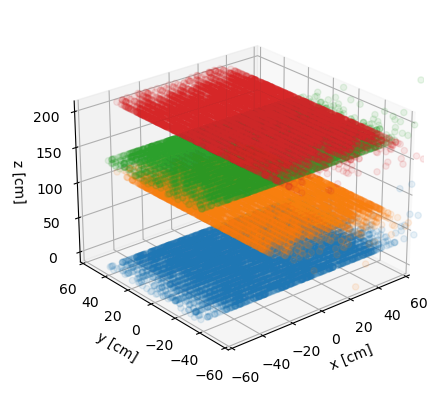

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)

n_plot=9000
for layer in range(1,5):
    mask = data["hit_ass"]==layer
    ax.scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot], data["hit_z"][mask][:n_plot], alpha=0.1, zorder=layer)

ax.view_init(elev=25, azim=230)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")

In [22]:
# layer=3
# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==77)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])
        
# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==66)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])

# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==125)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])

# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==123)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])

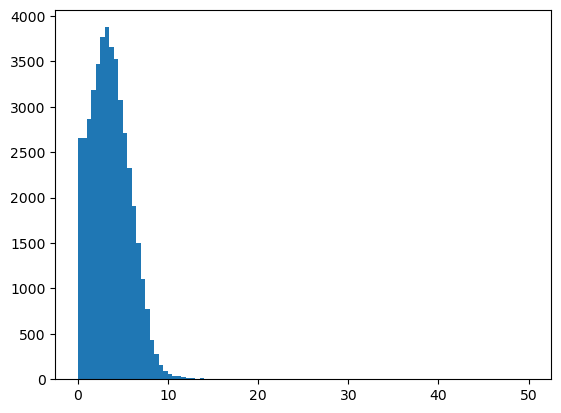

In [23]:
# Sort everything by time, with energy cut
inds_sort = np.argsort(data["hit_t"])
for key in data:
    data[key]=data[key]

hist(data["hit_t"][2:]-data["hit_t"][:-2], bins=100, range=(0,50));

In [33]:
events={key:[] for key in branches}

N_HIT_MIN=3
WINDOW=50 #ns

event_found=False
i=0
while i<(len(data["hit_x"])-N_HIT_MIN):
    if data["hit_t"][i+N_HIT_MIN-1]-data["hit_t"][i] <WINDOW:
        last_hit_ind = N_HIT_MIN-1
        # Find the last hit that is still within the time window
        for j in range(N_HIT_MIN, len(data["hit_x"])-N_HIT_MIN-i):
            if (data["hit_t"][i+j]-data["hit_t"][i])<WINDOW:
                last_hit_ind=j
            else:
                break

        # Record all hits within the window
        if len(np.unique(data["hit_z"][i:i+last_hit_ind+1]))==last_hit_ind+1:
            for key in events:
                events[key].append(data[key][i:i+last_hit_ind+1])
            # Update i
            i+=last_hit_ind
        else:
            i+=1

    else:
        i+=1

for key in events:
    events[key]=np.array(events[key], dtype=object)

print(len(events["hit_x"]), "events found")


34484 events found


Text(0, 0.5, 'Counts')

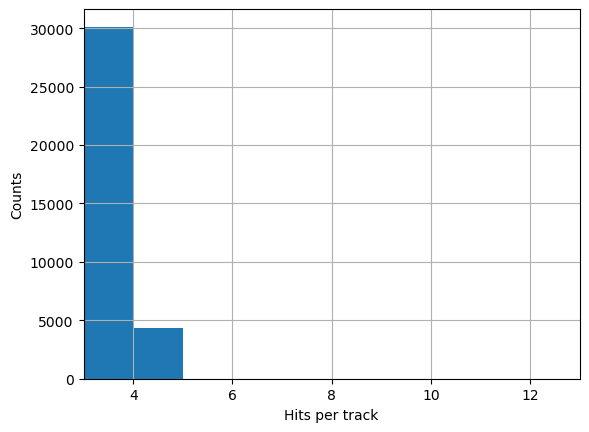

In [34]:
lengths = np.array([len(i) for i in events["hit_x"]])
nbins=10
hist(lengths,bins=nbins, range=(3,3+nbins));
xlim(3,3+nbins)
grid()
xlabel("Hits per track")
ylabel("Counts")

# estimated_rate_4hits = 80**2/60 * (0.8**2)/(2*3.141*2**2) *3600
# axhline(estimated_rate_4hits)

[  0. 100. 150. 200.]
[  0. 100. 150. 200.]
[  0. 100. 150. 200.]
[  0. 100. 150. 200.]
[  0. 100. 150. 200.]
[  0. 100. 150. 200.]
[  0. 100. 150. 200.]
[  0. 100. 150. 200.]


Text(0.5, 0, 'z [cm]')

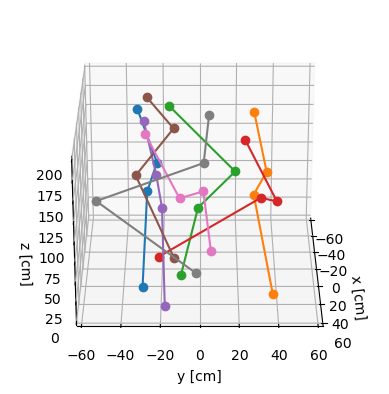

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)

nhit=4
mask_nhit = (lengths==nhit)
for ievent in range(8):
    x,y,z,t = events["hit_x"][mask_nhit][ievent], events["hit_y"][mask_nhit][ievent], events["hit_z"][mask_nhit][ievent], events["hit_t"][mask_nhit][ievent]
    if len(np.unique(z))!=nhit:
        continue

    inds = np.argsort(z)
    x,y,z,t = x[inds],y[inds],z[inds],t[inds]
    ax.plot(x,y,z, alpha=1, zorder=ievent, linestyle="-", marker="o")
    print(z)


ax.view_init(elev=25, azim=0)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")